# **Normalization techniques**

Dataset is already log-normalized

Using such a transform converts the distribution of ratios of abundance values of peptides into a more symmetric, almost normal distribution. This allows the use of several robust normalization techniques that have been developed for such data. Also, a log transform reduces the leverage of a low number of highly abundant species on the regression analysis used by these robust techniques

### Imports

In [73]:
import pandas as pd
import numpy as np
import csv
from matplotlib import pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import train_test_split 
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score,classification_report
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn import preprocessing
from scipy import stats
pd.set_option('display.max_columns', None)

### Normality test function

In [82]:
def norm_test(data):
    alpha = 1e-3
    k2, p = stats.normaltest(data)
    for i in p:
        if i < alpha:  # null hypothesis: x comes from a normal distribution
            print("not normally distr")
        else:
            print("normally distr")

### Get Dataset + prepare cluster target features

C:\Users\marti\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


not normally distr
not normally distr
not normally distr
normally distr
normally distr
not normally distr
not normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
not normally distr
not normally distr
not normally distr
normally distr
normally distr
normally distr
not normally distr
not normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
not normally distr
not normally distr
not normally distr
not normally distr
normally distr
not normally distr
normally distr
not normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
not normally distr
not normally distr
normally distr
normally distr
not normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
not normally distr
normally distr
normally distr
not normally distr
not normally dis

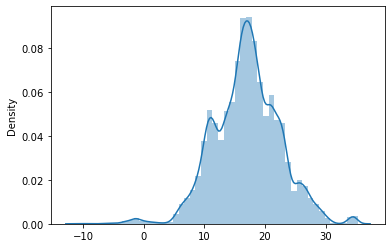

In [83]:
df = pd.read_csv("dataset\CSF_Proteomics_ADNI.csv")
df['binary_class'].replace({'stable':0,'decliner':1},inplace=True)
df['three_class'].replace({'slowDecline':0,'rapidDecline':1,'stable':2},inplace=True)

pheno = df.loc[:,'RID':'VISCODE']
data = df.loc[:,'A1AT.AVLTIDEK':'VTDB.VPTADLEDVLPLAEDITNILSK']

sns.distplot(data)
norm_test(data)

## Quantile Normalization

The quantile technique was the most unique in that an iterative process was not required for normalization. Additionally, this normalization technique does not force the means of replicate samples to converge upon a predetermined value, as was observed in the case of the other three normalization techniques (i.e., central tendency, linear regression, and local regression), where the mean of relative peptide abundances were forced to converge to zero. When the quantile technique was applied to our data, the mean of the common distribution following normalization fell within the range of means for the compared runs. This observation has an important implication related to the selection of a normalization technique and to the number of peptides common to all replicates runs used in the normalization process. Since we opted to perform central tendency, linear regression, and local regression normalization on a global scale, where measured abundances of all common peptides are used, we assumed that the leverage of peptide ratios containing biological variability on the mean relative abundance of the set of peptide ratios would not be significant. Such an assumption is commonly made for mRNA expression analysis where arrays are designed to target a large or complete set of open reading frames 21. In the case of high-throughput proteomics large number of peptides can be detected, but peptides can fail to be detected for many reasons (changes in the LC separation, the overshadowing of less abundant peptides by highly abundant peptides in the same spectrum, variations in MS performance, etc.) 3, 10. Hence, the mean relative abundance of replicate sets of peptide ratios may indeed lie above or below zero. In such a case, quantile normalization would be more suitable for reducing variability among these replicate runs.

C:\Users\marti\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally distr
normally d

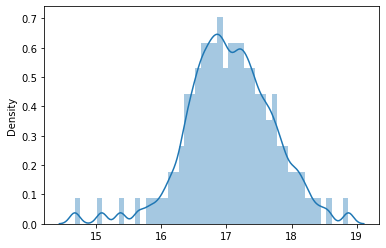

In [84]:
from scipy import stats

#QUANTILE NORMALIZATION
def quantile_normalize(df):
    df_sorted = pd.DataFrame(np.sort(df.values,
                                     axis=0), 
                             index=df.index, 
                             columns=df.columns)
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = np.arange(1, len(df_mean) + 1)
    df_qn =df.rank(method="min").stack().astype(int).map(df_mean).unstack()
    return df_qn


# compute quantile normalized data
df_qn=quantile_normalize(data)
sns.distplot(df_qn)
data = df_qn
norm_test(data)

## Box-cox transformation

Data must be positive !

The objective is to obtain a normal distribution of the transformed data (after transformation) and a constant variance.

If a logarithmic transformation is applied to this distribution, the differences between smaller values will be expanded (because the slope of the logarithmic function is steeper when values are small) whereas the differences between larger values will be reduced (because of the very moderate slope of the log distribution for larger values). If you inflate differences on the left tail and reduce differences on the right side tail, the result will be a symmetrical normal distribution, and a variance that is now constant (whatever the mean).

C:\Users\marti\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


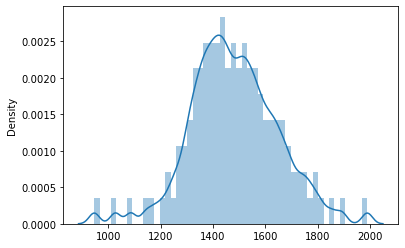

In [72]:
#compute box-cox transformation
df_bc = pd.DataFrame().reindex_like(data)

for col in df_qn:
    df_bc[col],_ = stats.boxcox(df_qn[col])
sns.distplot(df_bc)
data = df_qn

### Mean Normalization (residual extraction)

C:\Users\marti\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


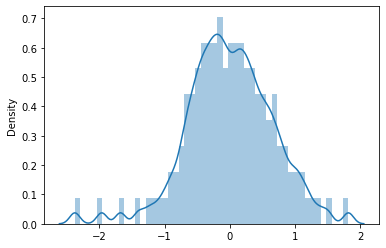

In [64]:
df_re = pd.DataFrame().reindex_like(data)

for col in df_re:
    df_re[col]=data[col] - data[col].mean()

sns.distplot(df_re)
data = df_re

### Min Max Normalization

C:\Users\marti\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


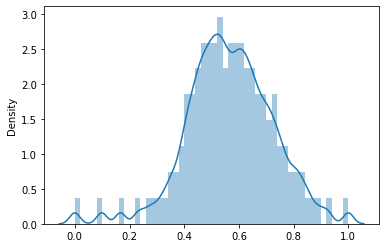

In [65]:
min_max_scaler = preprocessing.MinMaxScaler()
df_mm = min_max_scaler.fit_transform(data)

sns.distplot(df_mm)
data = df_mm